# libraries

In [23]:
import os
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import json
from functools import reduce

# Absolute path to your key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/tolgasabanoglu/Desktop/github/spatiotemporal/spatiotemporal-key.json"

# Initialize BigQuery client
client = bigquery.Client()

In [24]:
table_id = f"{client.project}.garmin_data.garmin_raw_data"
df = client.query(f"SELECT * FROM `{table_id}`").to_dataframe()
df

/Users/tolgasabanoglu/Desktop/github/spatiotemporal/spatiotemporal_env/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,filename,raw_json
0,body_battery_2025-09-22.json,"[{""date"": ""2025-09-22"", ""charged"": 45, ""draine..."
1,heart_rate_2025-04-17.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."
2,body_battery_2025-05-01.json,"[{""date"": ""2025-05-01"", ""charged"": 36, ""draine..."
3,sleep_2025-04-15.json,"{""dailySleepDTO"": {""id"": 1744676720000, ""userP..."
4,sleep_2025-06-28.json,"{""dailySleepDTO"": {""id"": 1751058151000, ""userP..."
...,...,...
5704,steps_2025-09-19.json,"[{""startGMT"": ""2025-09-18T15:00:00.0"", ""endGMT..."
5705,steps_2025-07-07.json,"[{""startGMT"": ""2025-07-06T22:00:00.0"", ""endGMT..."
5706,stress_2025-09-12.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."
5707,stress_2025-06-21.json,"{""userProfilePK"": 130724645, ""calendarDate"": ""..."


In [25]:
# Identify the type of JSON structure
def detect_json_type(raw):
    try:
        obj = json.loads(raw)
        if isinstance(obj, list):
            return 'list'
        elif isinstance(obj, dict):
            return 'dict'
        else:
            return 'other'
    except Exception:
        return 'invalid'

df['json_type'] = df['raw_json'].apply(detect_json_type)

# See how many of each type we have
print(df['json_type'].value_counts())

# Peek at unique filename prefixes (the metric types)
df['metric'] = df['filename'].str.extract(r'^([^_]+)')
print(df['metric'].value_counts())


json_type
dict    3429
list    2280
Name: count, dtype: int64
metric
body      1143
heart     1143
sleep     1143
stress    1143
steps     1137
Name: count, dtype: int64


In [26]:
# Copy the original dataframe
df_clean = df.copy()

# Function to normalize JSON
def normalize_json(x):
    if isinstance(x, str):
        x = json.loads(x)  # parse JSON string
    if isinstance(x, list):
        return pd.DataFrame(x)  # explode list of dicts
    elif isinstance(x, dict):
        return pd.DataFrame([x])  # wrap dict in a DataFrame
    else:
        return pd.DataFrame()  # empty fallback

# Create a dictionary to hold separate tidy dfs by filename prefix
tidy_dfs = {}

# Loop through unique filename prefixes (everything before the first '_')
for prefix in df_clean['filename'].str.split('_').str[0].unique():
    df_subset = df_clean[df_clean['filename'].str.startswith(prefix)]
    temp_list = []
    
    for _, row in df_subset.iterrows():
        temp_df = normalize_json(row['raw_json'])
        if not temp_df.empty:
            temp_df['filename'] = row['filename']  # keep filename
            temp_list.append(temp_df)
    
    if temp_list:
        tidy_dfs[prefix] = pd.concat(temp_list, ignore_index=True)

# Now tidy_dfs contains:
# keys: 'body', 'heart', 'sleep', 'stress', 'steps'
# values: the corresponding tidy DataFrames
# Example: inspect the first few rows of body_battery
tidy_dfs.keys()


dict_keys(['body', 'heart', 'sleep', 'stress', 'steps'])

# df structure

In [27]:

def get_all_column_names(dataframes: dict) -> None:
    """
    Iterates through a dictionary of DataFrames and prints the column names 
    for each one, displayed as a single, comma-separated list.
    
    Args:
        dataframes: A dictionary where keys are dataset names (str) and values 
                    are pandas DataFrames.
    """
    print("-" * 50)
    print("Dataset Column Inspection")
    print("-" * 50)

    for name, df in dataframes.items():
        # Using f-strings to format the output nicely
        print(f"\n[{name.upper()} Dataset ({len(df)} rows)]")
        
        # Check if the object is actually a DataFrame before getting columns
        if isinstance(df, pd.DataFrame):
            columns = df.columns.tolist()
            # Join all column names into a single comma-separated string for easy viewing
            print("Columns (List):")
            print(f"  {', '.join(columns)}")
        else:
            print("Warning: Item is not a pandas DataFrame.")


# Execute the function
get_all_column_names(tidy_dfs)


--------------------------------------------------
Dataset Column Inspection
--------------------------------------------------

[BODY Dataset (1143 rows)]
Columns (List):
  date, charged, drained, startTimestampGMT, endTimestampGMT, startTimestampLocal, endTimestampLocal, bodyBatteryValuesArray, bodyBatteryValueDescriptorDTOList, bodyBatteryDynamicFeedbackEvent, bodyBatteryActivityEvent, filename, endOfDayBodyBatteryDynamicFeedbackEvent

[HEART Dataset (1143 rows)]
Columns (List):
  userProfilePK, calendarDate, startTimestampGMT, endTimestampGMT, startTimestampLocal, endTimestampLocal, maxHeartRate, minHeartRate, restingHeartRate, lastSevenDaysAvgRestingHeartRate, heartRateValueDescriptors, heartRateValues, filename

[SLEEP Dataset (1143 rows)]
Columns (List):
  dailySleepDTO, sleepMovement, remSleepData, sleepLevels, sleepRestlessMoments, restlessMomentsCount, wellnessEpochRespirationDataDTOList, wellnessEpochRespirationAveragesList, respirationVersion, sleepHeartRate, sleepStress, s

# merging

In [45]:
# -----------------------------
# Step 1: Columns to keep per dataset
# -----------------------------
body_cols = ['charged', 'drained', 'bodyBatteryDynamicFeedbackEvent', 
             'bodyBatteryActivityEvent', 'endOfDayBodyBatteryDynamicFeedbackEvent']
heart_cols = ['maxHeartRate', 'minHeartRate', 'restingHeartRate', 
              'lastSevenDaysAvgRestingHeartRate', 'heartRateValueDescriptors', 'heartRateValues']
sleep_cols = ['dailySleepDTO', 'sleepMovement', 'remSleepData', 'sleepLevels', 
              'sleepRestlessMoments', 'restlessMomentsCount', 'wellnessEpochRespirationAveragesList',
              'respirationVersion', 'sleepHeartRate', 'sleepStress', 'sleepBodyBattery', 
              'hrvData', 'avgOvernightHrv', 'hrvStatus', 'bodyBatteryChange']
stress_cols = ['maxStressLevel', 'avgStressLevel', 'stressChartValueOffset']
steps_cols = ['steps', 'pushes', 'primaryActivityLevel', 'activityLevelConstant']

# -----------------------------
# Step 2: Function to extract date from filename
# -----------------------------
def extract_date_from_filename(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['filename'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0], errors='coerce')
    return df

# -----------------------------
# Step 3: Flatten array/dict columns
# -----------------------------
array_columns = [
    'bodyBatteryDynamicFeedbackEvent', 'bodyBatteryActivityEvent', 'endOfDayBodyBatteryDynamicFeedbackEvent', 
    'heartRateValueDescriptors', 'heartRateValues', 'dailySleepDTO', 'sleepMovement', 'sleepLevels',
    'sleepRestlessMoments', 'wellnessEpochRespirationAveragesList', 'sleepHeartRate', 'sleepStress', 'sleepBodyBattery',
    'hrvData', 'stressValuesArray'
]

def flatten_and_aggregate(arr):
    """Safely flatten list/array of lists or dicts and compute mean."""
    # Check if arr is a scalar missing value
    if arr is None or (np.isscalar(arr) and pd.isna(arr)):
        return np.nan

    # If it's a single-element array (e.g., np.array, pd.Series), convert to list
    if isinstance(arr, (np.ndarray, pd.Series)):
        arr = arr.tolist()
    
    # Ensure arr is iterable
    if not isinstance(arr, list):
        return np.nan

    values = []
    for item in arr:
        # list like [timestamp, value]
        if isinstance(item, list) and len(item) > 1 and isinstance(item[1], (int, float)):
            values.append(item[1])
        # dict with 'value' key
        elif isinstance(item, dict) and 'value' in item:
            val = item['value']
            if isinstance(val, (int, float)):
                values.append(val)
    return np.mean(values) if values else np.nan


# -----------------------------
# Step 4: Extract date, select columns, flatten arrays
# -----------------------------
def prepare_df(df, cols):
    df_sel = extract_date_from_filename(df)[cols + ['date']].copy()
    for col in array_columns:
        if col in df_sel.columns:
            df_sel[col + '_mean'] = df_sel[col].apply(flatten_and_aggregate)
            df_sel.drop(columns=[col], inplace=True)
    return df_sel

body_df = prepare_df(tidy_dfs['body'], body_cols)
heart_df = prepare_df(tidy_dfs['heart'], heart_cols)
sleep_df = prepare_df(tidy_dfs['sleep'], sleep_cols)
stress_df = prepare_df(tidy_dfs['stress'], stress_cols)
steps_df = prepare_df(tidy_dfs['steps'], steps_cols)

# -----------------------------
# Step 5: Merge all datasets on 'date'
# -----------------------------
daily_dfs = [body_df, heart_df, sleep_df, stress_df, steps_df]
merged_daily = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), daily_dfs)

# -----------------------------
# Step 6: Aggregate per day
# -----------------------------
def daily_aggregate(df):
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    other_cols = [c for c in df.columns if c not in numeric_cols + ['date']]
    
    agg_dict = {col: 'mean' for col in numeric_cols}
    for col in other_cols:
        agg_dict[col] = 'first'
    
    return df.groupby('date', as_index=False).agg(agg_dict)

merged_daily_agg = daily_aggregate(merged_daily)

# -----------------------------
# Step 7: Inspect final dataset
# -----------------------------
print(f"Aggregated daily dataset: {merged_daily_agg.shape[0]} rows, {merged_daily_agg.shape[1]} columns")
merged_daily_agg.head()


Aggregated daily dataset: 233 rows, 34 columns


,date,bodyBatteryDynamicFeedbackEvent_mean,bodyBatteryActivityEvent_mean,endOfDayBodyBatteryDynamicFeedbackEvent_mean,heartRateValueDescriptors_mean,heartRateValues_mean,restlessMomentsCount,respirationVersion,avgOvernightHrv,bodyBatteryChange,...,minHeartRate,restingHeartRate,lastSevenDaysAvgRestingHeartRate,remSleepData,hrvStatus,maxStressLevel,avgStressLevel,stressChartValueOffset,primaryActivityLevel,activityLevelConstant
0,2025-02-25,NaN,NaN,NaN,NaN,85.010638,NaN,NaN,NaN,NaN,...,69,75,75,None,None,96,54,1,none,True
1,2025-02-26,NaN,NaN,NaN,NaN,86.863889,32.0,200.0,33.0,51.0,...,59,64,70,True,NONE,97,46,1,sleeping,True
2,2025-02-27,NaN,NaN,NaN,NaN,83.918803,41.0,200.0,27.0,28.0,...,63,68,69,True,NONE,96,43,1,sleeping,True
3,2025-02-28,NaN,NaN,NaN,NaN,79.884498,42.0,200.0,42.0,86.0,...,56,59,67,True,NONE,99,25,1,sleeping,True
4,2025-03-01,NaN,NaN,NaN,NaN,85.211949,35.0,200.0,36.0,54.0,...,56,60,65,True,NONE,99,37,1,sleeping,True


# cleaning

## check the missing columns

In [46]:
# === Missing Values (>50%) ===
missing_ratio = merged_daily_agg.isna().mean() * 100  # percentage of missing
missing_over_50 = missing_ratio[missing_ratio > 50].sort_values(ascending=False)

print("=== Columns with >50% Missing Values ===")
if missing_over_50.empty:
    print("✅ No columns have more than 50% missing values.")
else:
    print(missing_over_50.to_string(float_format="%.2f"))

=== Columns with >50% Missing Values ===
bodyBatteryDynamicFeedbackEvent_mean           100.00
bodyBatteryActivityEvent_mean                  100.00
endOfDayBodyBatteryDynamicFeedbackEvent_mean   100.00
heartRateValueDescriptors_mean                 100.00
dailySleepDTO_mean                             100.00
sleepMovement_mean                             100.00
sleepLevels_mean                               100.00
wellnessEpochRespirationAveragesList_mean      100.00


## fill the missing columns

In [47]:
import numpy as np

# === 2. Find and Drop Columns with >50% Missing Values ===
missing_ratio = merged_daily_agg.isna().mean() * 100
cols_to_drop = missing_ratio[missing_ratio > 50].index.tolist()

# Add columns with only one unique value
constant_cols = merged_daily_agg.columns[merged_daily_agg.nunique() <= 1].tolist()
cols_to_drop.extend(constant_cols)

# Remove duplicates if any
cols_to_drop = list(set(cols_to_drop))

print("=== Dropping Columns with >50% Missing Values or Single Constant Value ===")
print(cols_to_drop)

merged_daily_agg = merged_daily_agg.drop(columns=cols_to_drop)
print(f"\n✅ Dropped {len(cols_to_drop)} columns. Remaining columns: {merged_daily_agg.shape[1]}")

# === 3. Fill Missing Values for Remaining Columns ===
for col in merged_daily_agg.columns:
    dtype = merged_daily_agg[col].dtype

    if np.issubdtype(dtype, np.number):
        # Numeric → median
        median_val = merged_daily_agg[col].median()
        merged_daily_agg[col] = merged_daily_agg[col].fillna(median_val)

    elif dtype == 'O':
        # Object → mode or "Unknown"
        mode_val = merged_daily_agg[col].mode()
        fill_val = mode_val[0] if not mode_val.empty else "Unknown"
        merged_daily_agg[col] = merged_daily_agg[col].fillna(fill_val)

    elif np.issubdtype(dtype, np.datetime64):
        # Datetime → forward fill then backward fill
        merged_daily_agg[col] = merged_daily_agg[col].ffill().bfill()

print("\n✅ Missing values handled successfully (no warnings).")
print(f"✅ Final shape: {merged_daily_agg.shape}")
print(f"✅ Remaining missing values total: {merged_daily_agg.isna().sum().sum()}")


=== Dropping Columns with >50% Missing Values or Single Constant Value ===
['heartRateValueDescriptors_mean', 'pushes', 'respirationVersion', 'sleepLevels_mean', 'wellnessEpochRespirationAveragesList_mean', 'bodyBatteryActivityEvent_mean', 'endOfDayBodyBatteryDynamicFeedbackEvent_mean', 'stressChartValueOffset', 'remSleepData', 'dailySleepDTO_mean', 'sleepMovement_mean', 'bodyBatteryDynamicFeedbackEvent_mean']

✅ Dropped 12 columns. Remaining columns: 22

✅ Missing values handled successfully (no warnings).
✅ Final shape: (233, 22)
✅ Remaining missing values total: 0


/var/folders/1g/45y5svr534s7c8sx09294sxc0000gn/T/ipykernel_2071/3506003875.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_daily_agg[col] = merged_daily_agg[col].fillna(fill_val)


## data str

In [48]:
print("=== Columns and Data Types ===")
for col, dtype in merged_daily_agg.dtypes.items():
    print(f"{col:40}  {dtype}")


=== Columns and Data Types ===
date                                      datetime64[ns]
heartRateValues_mean                      float64
restlessMomentsCount                      float64
avgOvernightHrv                           float64
bodyBatteryChange                         float64
sleepRestlessMoments_mean                 float64
sleepHeartRate_mean                       float64
sleepStress_mean                          float64
sleepBodyBattery_mean                     float64
hrvData_mean                              float64
steps                                     float64
charged                                   int64
drained                                   int64
maxHeartRate                              int64
minHeartRate                              int64
restingHeartRate                          int64
lastSevenDaysAvgRestingHeartRate          int64
hrvStatus                                 object
maxStressLevel                            int64
avgStressLevel             

## create lagged versions of key features

In [49]:
import pandas as pd

# Make a copy to avoid modifying the original
df_lagged = merged_daily_agg.copy()

# Columns selected for lagging (time-varying, meaningful)
lag_columns = [
    'sleepRestlessMoments_mean',
    'sleepHeartRate_mean',
    'sleepStress_mean',
    'sleepBodyBattery_mean',
    'avgOvernightHrv',
    'restingHeartRate',
    'bodyBatteryChange',
    'heartRateValues_mean',
    'restlessMomentsCount',
    'hrvData_mean',
    'steps',
    'charged',
    'drained'
]

# Sort by date just in case
df_lagged = df_lagged.sort_values('date').reset_index(drop=True)

# Create lagged features for 1 day (t-1)
for col in lag_columns:
    df_lagged[f'{col}_lag1'] = df_lagged[col].shift(1)

# Optionally, drop the first row which now has NaNs due to lag
df_lagged = df_lagged.dropna(subset=[f'{col}_lag1' for col in lag_columns])

# Check the new columns
print("✅ Lagged features created. Columns now include:")
print([col for col in df_lagged.columns if '_lag1' in col])
print("\nFinal shape:", df_lagged.shape)


✅ Lagged features created. Columns now include:
['sleepRestlessMoments_mean_lag1', 'sleepHeartRate_mean_lag1', 'sleepStress_mean_lag1', 'sleepBodyBattery_mean_lag1', 'avgOvernightHrv_lag1', 'restingHeartRate_lag1', 'bodyBatteryChange_lag1', 'heartRateValues_mean_lag1', 'restlessMomentsCount_lag1', 'hrvData_mean_lag1', 'steps_lag1', 'charged_lag1', 'drained_lag1']

Final shape: (232, 35)


# correlation

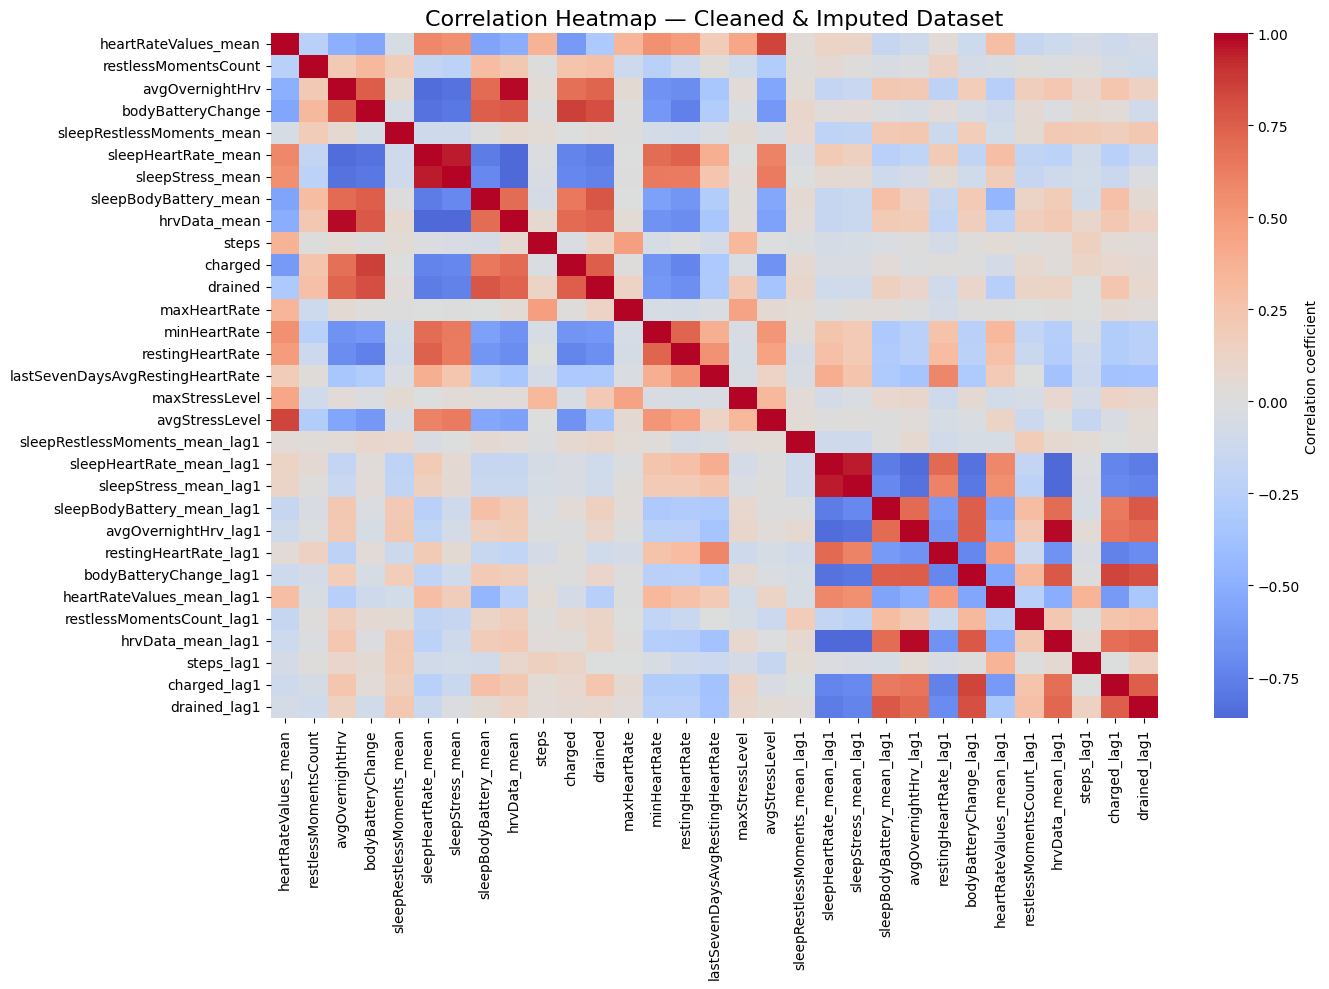

In [50]:
# --- 3. Correlation matrix ---
corr = df_lagged.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=False,
    fmt='.2f',
    cbar_kws={'label': 'Correlation coefficient'}
)
plt.title('Correlation Heatmap — Cleaned & Imputed Dataset', fontsize=16)
plt.tight_layout()
plt.show()


In [51]:
# Compute correlation matrix
corr = df_lagged.select_dtypes(include=[np.number]).corr()

# Take the upper triangle (to avoid duplicate pairs)
upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find pairs with |correlation| > 0.8
strong_corrs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature_1', 'level_1': 'Feature_2', 0: 'Correlation'})
)

strong_corrs = strong_corrs[strong_corrs['Correlation'].abs() > 0.9]\
    .sort_values(by='Correlation', ascending=False)

# Display results
if not strong_corrs.empty:
    print("🔍 Strong correlations (|r| > 0.9):")
    display(strong_corrs)
else:
    print("No correlations above 0.8 found.")


🔍 Strong correlations (|r| > 0.9):


,Feature_1,Feature_2,Correlation
433,avgOvernightHrv_lag1,hrvData_mean_lag1,0.985358
64,avgOvernightHrv,hrvData_mean,0.985358
399,sleepHeartRate_mean_lag1,sleepStress_mean_lag1,0.949442
140,sleepHeartRate_mean,sleepStress_mean,0.949442


# ML/DL

In [52]:
# Load your algorithm script
import sys
# Add path to the script folder
sys.path.append("/Users/tolgasabanoglu/Desktop/github/spatiotemporal/notebooks/")
# Import your module
import algorithms  # assuming the file is algorithms.py

import importlib
importlib.reload(algorithms)


<module 'algorithms' from '/Users/tolgasabanoglu/Desktop/github/spatiotemporal/notebooks/algorithms.py'>

## random forest

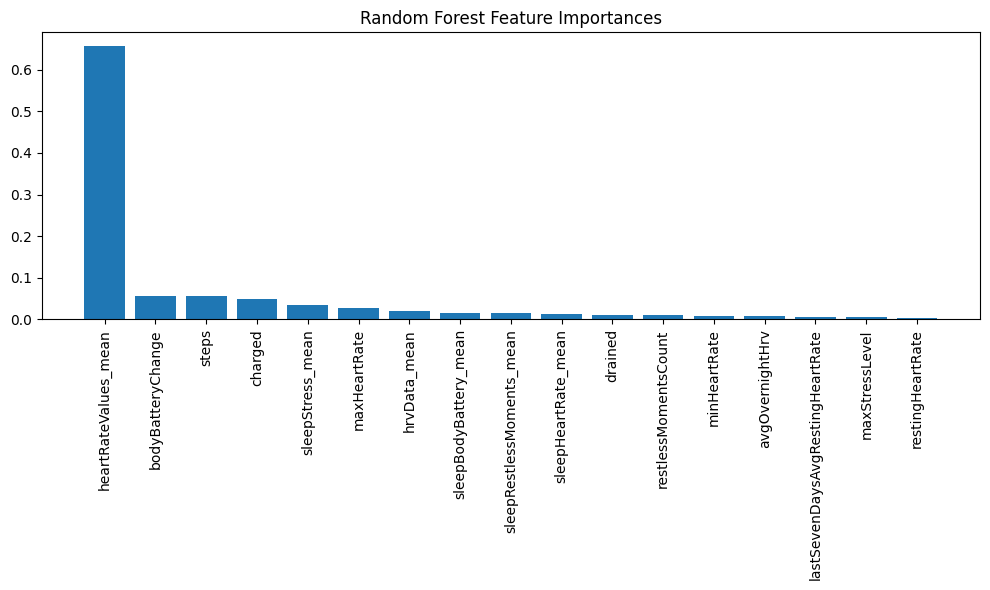

{'r2': 0.8067669931887506, 'rmse': np.float64(3.30981655659311), 'mae': 2.6509574468085106}


/Users/tolgasabanoglu/Desktop/github/spatiotemporal/spatiotemporal_env/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
# Select only numeric columns
numeric_cols = merged_daily_agg.select_dtypes(include=['int64','float64']).columns.tolist()
# Remove the target from features
X_cols = [col for col in numeric_cols if col != target]

# Train Random Forest
results = algorithms.train_models(
    df=merged_daily_agg,
    y=target,
    x=X_cols
)

rf_results = results["RandomForest"]
print(rf_results["metrics"])
